In [ ]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os

# Specify the paths to your original images and the directory to save augmented images
original_images_path = '/content/drive/MyDrive/Capstone/Fungal V Non-Fungal/fungal_infection'
augmented_images_path = '/content/fungal_augmented_new'

# Create the directory to save augmented images if it doesn't exist
os.makedirs(augmented_images_path, exist_ok=True)

# Specify the augmentation parameters
rotation_angles = [30, 60, 90, 120, 150]  # Rotation angles
flipping_codes = [0, 1, -1]  # Flipping codes
brightness_factors = [0.6, 1.2]  # Brightness adjustment factors
saturation_factors = [0.6, 1.2]  # Saturation adjustment factors

# Iterate through each original image
for filename in os.listdir(original_images_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust the file extension as needed
        # Load the original image
        image_path = os.path.join(original_images_path, filename)
        image = cv2.imread(image_path)

        # Generate rotated variations
        for angle in rotation_angles:
            # Rotate the image
            rotation_matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1.0)
            rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

            # Save the rotated image
            save_path = os.path.join(augmented_images_path, f'rotated_{angle}_{filename}')
            cv2.imwrite(save_path, rotated_image)

        # Generate flipped variations
        for code in flipping_codes:
            # Flip the image
            flipped_image = cv2.flip(image, code)

            # Save the flipped image
            flip_code_str = 'h' if code == 0 else 'v' if code == 1 else 'hv'
            save_path = os.path.join(augmented_images_path, f'flipped_{flip_code_str}_{filename}')
            cv2.imwrite(save_path, flipped_image)

        # Generate brightness variations
        for factor in brightness_factors:
            # Adjust the image brightness
            brightened_image = cv2.convertScaleAbs(image, alpha=factor, beta=0)
            darkened_image = cv2.convertScaleAbs(image, alpha=1.0, beta=-50)

            # Save the brightened and darkened images
            save_path_brightened = os.path.join(augmented_images_path, f'brightened_{int(factor*10)}_{filename}')
            save_path_darkened = os.path.join(augmented_images_path, f'darkened_{int(factor*10)}_{filename}')
            cv2.imwrite(save_path_brightened, brightened_image)
            cv2.imwrite(save_path_darkened, darkened_image)

        # Generate saturation variations
        for factor in saturation_factors:
            # Convert the image to HSV color space
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # Scale the saturation channel
            hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1] * factor, 0, 255)

            # Convert the image back to BGR color space


In [ ]:
# grader-required-cell

source_path = '/content/drive/MyDrive/Capstone/Fungal V Non-Fungal'

source_path_fungal = os.path.join(source_path, 'fungal_infection')
source_path_non_fungal = os.path.join(source_path, 'non_fungal')

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_fungal))} images of Fungal Infection.")
print(f"There are {len(os.listdir(source_path_non_fungal))} images of Non Fungal")

There are 11 images of Fungal Infection.
There are 51 images of Non Fungal


In [ ]:
# grader-required-cell

# Define root directory
root_dir = '/content/fungal vs non fungal'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """
  ### START CODE HERE
  os.makedirs(root_path)
  train_dir = os.path.join(root_path, 'training')
  val_dir = os.path.join(root_path, 'validation')

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  train_cats_dir = os.path.join(train_dir, 'fungal')
  train_dogs_dir = os.path.join(train_dir, 'nonfungal')
  val_cats_dir = os.path.join(val_dir, 'fungal')
  val_dogs_dir = os.path.join(val_dir, 'nonfungal')

  os.makedirs(train_cats_dir)
  os.makedirs(train_dogs_dir)
  os.makedirs(val_cats_dir)
  os.makedirs(val_dogs_dir)

  pass


  ### END CODE HERE


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/fungal vs non fungal/training
/content/fungal vs non fungal/validation
/content/fungal vs non fungal/training/fungal
/content/fungal vs non fungal/training/nonfungal
/content/fungal vs non fungal/validation/fungal
/content/fungal vs non fungal/validation/nonfungal


In [ ]:
import random

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """

  file_list = []

  for file in os.listdir(SOURCE_DIR):
    file_path = os.path.join(SOURCE_DIR, file)
    if os.path.getsize(file_path) == 0:
      print(file + " is zero length, so ignoring.")
    else:
      file_list.append(file_path)

  random.shuffle(file_list)  # Shuffle the file list randomly

  train_num_items = int(round(len(file_list) * SPLIT_SIZE, 0))
  train_list = file_list[:train_num_items]
  val_list = file_list[train_num_items:]

  for f in train_list:
    copyfile(f, TRAINING_DIR + os.path.basename(f))
  for f in val_list:
    copyfile(f, VALIDATION_DIR + os.path.basename(f))

  pass

In [ ]:
# grader-required-cell

# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/content/fungal_augmented_new"
DOG_SOURCE_DIR = "/content/drive/MyDrive/Capstone/Fungal V Non-Fungal/non_fungal"

TRAINING_DIR = "/content/fungal vs non fungal/training"
VALIDATION_DIR = "/content/fungal vs non fungal/validation"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "fungal/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "fungal/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "nonfungal/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "nonfungal/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .8

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal fungal directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original nonfungal directory has {len(DOG_SOURCE_DIR)} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of fungal for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of nonfungal for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of fungal for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of nonfungal for validation")



Original fungal directory has 132 images
Original nonfungal directory has 62 images

There are 106 images of fungal for training
There are 41 images of nonfungal for training
There are 26 images of fungal for validation
There are 10 images of nonfungal for validation


In [ ]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(
    rescale=1.0/255.)
    # rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest')
    # rescale=1.0/255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True,)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='binary',
                                                      target_size=(128, 128))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(
    rescale=1.0/255.)
    # rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=16,
                                                                class_mode='binary',
                                                                target_size=(128, 128))
  ### END CODE HERE
  return train_generator, validation_generator

In [ ]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 147 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [ ]:
# grader-required-cell

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9:
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(),
      # 512 neuron hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])


  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE

  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)      

In [ ]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
model = create_model()
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    verbose = 1,
                    callbacks=callbacks)

Epoch 1/50
10/10 [==============================] - 20s 906ms/step - loss: 0.6165 - accuracy: 0.6939 - val_loss: 0.5299 - val_accuracy: 0.7222
Epoch 2/50
10/10 [==============================] - 7s 694ms/step - loss: 0.5081 - accuracy: 0.7347 - val_loss: 0.4517 - val_accuracy: 0.8056
Epoch 3/50
10/10 [==============================] - 9s 959ms/step - loss: 0.4287 - accuracy: 0.7347 - val_loss: 0.4720 - val_accuracy: 0.7500
Epoch 4/50
10/10 [==============================] - 10s 1s/step - loss: 0.4006 - accuracy: 0.7347 - val_loss: 0.4610 - val_accuracy: 0.7222
Epoch 5/50
10/10 [==============================] - 7s 721ms/step - loss: 0.3778 - accuracy: 0.7687 - val_loss: 0.4514 - val_accuracy: 0.6667
Epoch 6/50
10/10 [==============================] - 7s 686ms/step - loss: 0.4001 - accuracy: 0.7687 - val_loss: 0.4803 - val_accuracy: 0.8056
Epoch 7/50
10/10 [==============================] - 8s 905ms/step - loss: 0.4266 - accuracy: 0.7211 - val_loss: 0.4660 - val_accuracy: 0.6667
Epoch 8

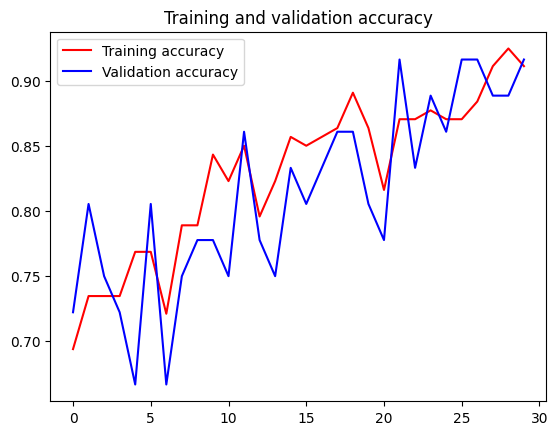

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image  # Import from tf.keras instead of keras

uploaded = files.upload()

for fn in uploaded.keys():
  # Predicting images
  path = fn
  img = image.load_img(path, target_size=(128, 128))  # Use tf.keras.preprocessing.image.load_img
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)


Saving dog210430_08_01_30_pic0.jpg to dog210430_08_01_30_pic0.jpg
Saving dog210610_48_02_15_pic0.jpg to dog210610_48_02_15_pic0.jpg
Saving Dog210623_08_02_37_pic0.jpg to Dog210623_08_02_37_pic0.jpg
Saving Dog210708_01_02_01_pic0.jpg to Dog210708_01_02_01_pic0.jpg
1/1 [==============================] - 0s 248ms/step
dog210430_08_01_30_pic0.jpg
[[0.]]
1/1 [==============================] - 0s 18ms/step
dog210610_48_02_15_pic0.jpg
[[3.4280497e-36]]
1/1 [==============================] - 0s 21ms/step
Dog210623_08_02_37_pic0.jpg
[[1.]]
1/1 [==============================] - 0s 21ms/step
Dog210708_01_02_01_pic0.jpg
[[0.]]


In [ ]:
class_labels = ['fungal', 'non-fungal']

for fn in uploaded.keys():
    # Predicting images
    path = fn
    img = image.load_img(path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    predicted_label = class_labels[int(classes[0][0])]

    print(fn)
    print(predicted_label)


1/1 [==============================] - 0s 41ms/step
dog210430_08_01_30_pic0.jpg
fungal
1/1 [==============================] - 0s 22ms/step
dog210610_48_02_15_pic0.jpg
fungal
1/1 [==============================] - 0s 21ms/step
Dog210623_08_02_37_pic0.jpg
non-fungal
1/1 [==============================] - 0s 22ms/step
Dog210708_01_02_01_pic0.jpg
fungal


In [ ]:
# EXERCISE: Save the trained model as a Keras HDF5 file.

saved_model_path = "./my_model.h5"
model.save(saved_model_path)

# YOUR CODE HERE

In [ ]:
!pip install tensorflow==2.2
!pip install tensorflowjs
import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing 

• Using TensorFlow Version: 2.12.0


In [ ]:
# EXERCISE: Use the tensorflow.js converter to convert the saved Keras model into JSON format.
# YOUR CODE HERE
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2023-06-12 06:48:40.532853: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import zipfile

# Specify the filenames
h5_file = "./my_model.h5"
json_file = "./model.json"
bin_file1 = "./group1-shard1of3.bin"
bin_file2 = "./group1-shard2of3.bin"
bin_file3 = "./group1-shard3of3.bin"

# Create a zip file
zip_file_name = "fungal vs non fungal.zip"
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    # Add the h5 file to the zip
    zipf.write(h5_file, arcname='my_model.h5')

    # Add the json file to the zip
    zipf.write(json_file, arcname='model.json')

    # Add the bin files to the zip
    zipf.write(bin_file1, arcname='group1-shard1of3.bin')
    zipf.write(bin_file2, arcname='group1-shard2of3.bin')
    zipf.write(bin_file3, arcname='group1-shard3of3.bin')

print("Output files zipped successfully!")

Output files zipped successfully!
